# Deep Q-learning for Atari Breakout

![Atari_Brakout_image](maxresdefault.jpg)

This project implements Deep Q-Learning (DQN) to solve the classic Atari game Breakout, using the Gymnasium (formerly OpenAI Gym) framework. Atari Breakout is a simple arcade game where a paddle is controlled to bounce a ball and break bricks. The goal is to clear all the bricks without letting the ball fall below the paddle. It is widely used as a benchmark for reinforcement learning algorithms because of its straightforward yet challenging environment.

### What is Deep Q-Learning?

Deep Q-Learning is an extension of Q-Learning, a fundamental algorithm in reinforcement learning (RL). In traditional Q-Learning, an agent learns to make decisions by estimating the "Q-values" for state-action pairs. These Q-values represent the expected future rewards of taking a specific action from a particular state. The agent updates these values iteratively based on its interactions with the environment.

However, Q-Learning struggles in environments with high-dimensional state spaces, such as images. This is where Deep Q-Learning comes into play. Instead of storing and updating a Q-value table, DQN leverages a deep neural network to approximate the Q-function. This neural network takes in raw pixel data from the game (such as frames from Breakout) and predicts Q-values for all possible actions, allowing the agent to learn directly from high-dimensional sensory input.

### Atari Breakout as an RL Environment

In the Atari Breakout environment, the state consists of a sequence of frames representing the game screen, and the agent's goal is to learn the optimal strategy for moving the paddle left or right to keep the ball in play and maximize the reward (by breaking as many bricks as possible). The reward system is simple:

* The agent gets a positive reward for breaking bricks.
* It receives a penalty if it lets the ball fall past the paddle.

Breakout serves as a great testbed for DQN because it requires the agent to learn timing, precision, and planning over long-term rewards. By employing frame stacking, state preprocessing, and deep convolutional networks, the agent can effectively learn to master the game over time.

This project demonstrates the full pipeline, from building the DQN model to training it on the Breakout environment, while tracking key metrics like rewards, Q-scores, and losses during training.

## Libraries

The line `os.environ["KERAS_BACKEND"]="tensorflow"` sets an environment variable in Python that specifies which backend Keras should use for its operations.

In [3]:
import os

os.environ["KERAS_BACKEND"]="tensorflow"

import keras
from keras import layers

import ale_py
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

## Setup and Environment Configuration for Deep Q-Learning

This code configures the necessary parameters and environment for training a Deep Q-Learning (DQN) agent using the Atari **Breakout** game.

1. **Configuration Parameters**: 
   - `seed=42`: Sets a random seed for reproducibility of results.
   - `gamma=0.99`: Discount factor, which determines how much future rewards are worth compared to immediate rewards. A value closer to 1.0 means the agent values long-term rewards.
   - `epsilon=1.0`: Initial value for the **epsilon-greedy** exploration strategy, where the agent takes random actions with probability epsilon. 
   - `epsilon_min=0.1`: Minimum value for epsilon. As the agent trains, epsilon will decay towards this value, reducing random actions and focusing on the learned policy.
   - `epsilon_max=1.0`: Maximum value for epsilon at the start of training.
   - `epsilon_interval=(epsilon_max - epsilon_min)`: Defines the rate at which epsilon decreases over time.
   - `batch_size=32`: Size of the sample of experience data taken from the replay buffer to update the model.
   - `max_steps_per_episode=10000`: The maximum number of steps the agent can take in a single episode.
   - `max_episodes=10`: Limits the number of episodes for training. If set below 1, the agent will keep training until the environment is "solved."

2. **Atari Environment**: 
   - `env=gym.make("ALE/Breakout-v5")`: Initializes the Atari **Breakout** environment from Gym's ALE (Arcade Learning Environment) library.
   - `AtariPreprocessing(env, frame_skip=1)`: Preprocesses the raw environment input, including frame skipping to speed up training.
   - `FrameStack(env, 4)`: Stacks four consecutive frames to provide the agent with temporal context, helping it understand movement in the game.
   - `env.reset(seed=seed)`: Resets the environment and sets the random seed for reproducibility. 

This setup prepares the environment and agent for deep Q-learning on the Atari Breakout game, defining key hyperparameters and configuring the agent's exploration strategy.

In [4]:
# Configuration parameters for the whole setup
seed=42
gamma=0.99                                                 # Discount factor for past rewards
epsilon=1.0                                                # Epsilon greedy parameter
epsilon_min=0.1                                            # Minimum epsilon greedy parameter
epsilon_max=1.0                                            # Maximum epsilon greedy parameter
epsilon_interval=(epsilon_max - epsilon_min)               # Rate at which to reduce chance of random action being taken
batch_size=32                                              # Size of batch taken from replay buffer
max_steps_per_episode=10000
max_episodes=10                                            # Limit training episodes, will run until solved if smaller than 1

# Use the Atari environment

# Specify the `render_mode` parameter to show the attempts of the agent in a pop up window.
env=gym.make("ALE/Breakout-v5")                 # env= (..., render_mode="human")

# Environment preprocessing
env=AtariPreprocessing(env, frame_skip=1)

# Stack four frames
env=FrameStack(env, 4)
env.reset(seed=seed)


(<gymnasium.wrappers.frame_stack.LazyFrames at 0x7c56155a7510>,
 {'lives': 5,
  'episode_frame_number': 44,
  'frame_number': 44,
  'seeds': (3444837047, 2669555309)})

## Building the Q-Network for Action Prediction

This code defines and constructs the **Q-Network**, which is the neural network used in Deep Q-Learning to predict Q-values for the Atari **Breakout** game. The Q-values represent the expected future rewards for each possible action, helping the agent decide which action to take at each step.

- **num_actions=4**: This variable represents the number of possible actions the agent can take in the Atari Breakout game (e.g., move left, move right, do nothing, etc.).

- **create_q_model()**: This function builds the architecture of the Q-Network, which is modeled according to the DeepMind paper's specifications:
  - **Lambda Layer**: A preprocessing step that transposes the input tensor to rearrange the dimensions from (4, 84, 84) to (84, 84, 4), which is the expected format for the convolutional layers.
  - **Conv2D Layers**: Three convolutional layers extract spatial features from the stacked game frames, helping the network understand the visual patterns in the game environment.
  - **Flatten Layer**: Flattens the output of the convolutional layers into a single vector that can be fed into fully connected layers.
  - **Dense Layers**: A fully connected layer with 512 neurons applies the learned features and reduces them before the final output.
  - **Output Layer**: A dense layer with `num_actions` neurons, where each neuron outputs the Q-value for one of the possible actions. The linear activation is used here since Q-values can take any real value.

- **model and model_target**: 
  - `model=create_q_model()`: The main Q-network, which will predict the Q-values for each action and guide the agent's decisions.
  - `model_target=create_q_model()`: The target network, which provides more stable future reward predictions by updating its weights every 10,000 steps. This helps stabilize the training process. 

Together, these models form the core of the deep Q-learning algorithm, allowing the agent to learn from the environment and optimize its actions over time.

In [5]:
num_actions=4

def create_q_model():

  # Network defined by the Deepmind paper

  return keras.Sequential(
      [
          layers.Lambda(
              lambda tensor: keras.ops.transpose(tensor, [0, 2, 3, 1]),
              output_shape=(84, 84, 4),
              input_shape=(4, 84, 84)
          ),
          # Convolutions on the frames on the screen
          layers.Conv2D(32, 8, strides=4, activation='relu', input_shape=(4, 84, 84)),
          layers.Conv2D(64, 4, strides=2, activation='relu'),
          layers.Conv2D(64, 3, strides=1, activation='relu'),
          layers.Flatten(),
          layers.Dense(512, activation='relu'),
          layers.Dense(num_actions, activation='linear')
      ]
  )

# The first model makes the predictions for Q-values which are used to
# make a action.
model=create_q_model()

# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target=create_q_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Saving and Visualizing Environment Frames

This code defines a function, `save_env_images()`, that captures and visualizes a frame from the game environment during the training of the agent. It also saves the frame as an image file, which helps monitor the agent’s interaction with the environment.

- **Function Purpose**: `save_env_images(state, frame_count)` is designed to visualize the current state of the game and save it as a PNG image. This can be useful for tracking the agent's progress or debugging.
  
- **Handling Multi-Frame Observations**: If the `state` has more than one frame (e.g., multiple frames are stacked for better context), the function selects the first frame for display.
  
- **Visualization with `matplotlib`**: 
  - The frame is displayed using `plt.imshow()`, where the color map is set to 'plasma'. You can customize the color map (e.g., switch to grayscale) based on preference.
  - It also adds a title indicating the frame number and hides the axis for a cleaner display.

- **Saving the Frame**: The image is saved with a filename that includes the frame count (`frame_{frame_count}.png`), allowing for organized tracking of the training frames over time.

This function is crucial for visual monitoring during deep Q-learning, offering a way to observe how the agent perceives and interacts with its environment.

In [7]:
# Define a function to display and save the environment frame

def save_env_images(state, frame_count):
  plt.figure(figsize=(6, 6))

  # Select the first channel if the state has more than 3 dimensions (for multi-frame observations)
  if state.shape[0]>1:
    state=state[0]                              # Select the first frame for visualization

  plt.imshow(state, cmap='plasma')                # Choose 'gray' or any color map like 'plasma'
  plt.title(f"Frame {frame_count}")
  plt.axis('off')
  plt.savefig(f"frame_{frame_count}.png")       # Save image
  plt.show()                                    # Display image

## Deep Q-Learning Training Loop

This code implements the main training loop for a Deep Q-Learning agent interacting with the Atari Breakout environment. The loop is responsible for executing actions, updating the model, and maintaining the experience replay buffer.

- **Optimizer Configuration**: The Adam optimizer is initialized with a specific learning rate and gradient clipping. This choice is based on improvements in training time compared to the RMSProp optimizer mentioned in the DeepMind paper.

- **Experience Replay Buffers**: Multiple lists are created to store actions, states, rewards, and done flags, which facilitate experience replay. These buffers are essential for breaking the correlation between consecutive samples and improving training stability.

- **Epsilon-Greedy Strategy**: The agent employs an epsilon-greedy policy for exploration, where the probability of taking a random action decays over time. This encourages the agent to explore initially while gradually shifting towards exploitation of learned policies.

- **Environment Interaction**: The agent interacts with the environment in a loop, capturing state transitions, rewards, and whether the episode has ended. The environment’s state is updated after each action.

- **Model Training**: The model is updated every fourth action, provided there is sufficient experience in the replay buffer. A batch of experiences is sampled, and the Q-values for these experiences are calculated using the target network to ensure stability. The loss is computed using the Huber loss function, which is less sensitive to outliers than the mean squared error.

- **Target Network Update**: The target network is periodically updated with the weights of the main model. This ensures that the target Q-values remain stable during training.

- **Reward Tracking**: Running rewards are calculated to monitor the agent’s performance, with the condition set to consider the task solved if the average reward exceeds a threshold.

- **Termination Conditions**: The loop checks for two termination conditions: if the agent has solved the environment or if the maximum number of episodes has been reached. The rewards history is also managed to prevent excessive memory usage.

This training loop encapsulates the core functionality needed for the agent to learn optimal actions in the Atari Breakout environment through iterative experience and model updates.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


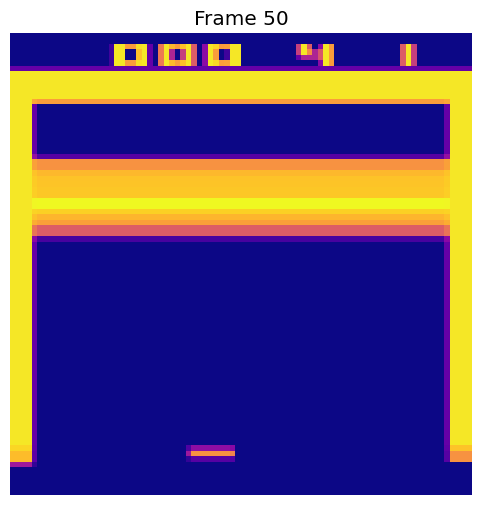

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


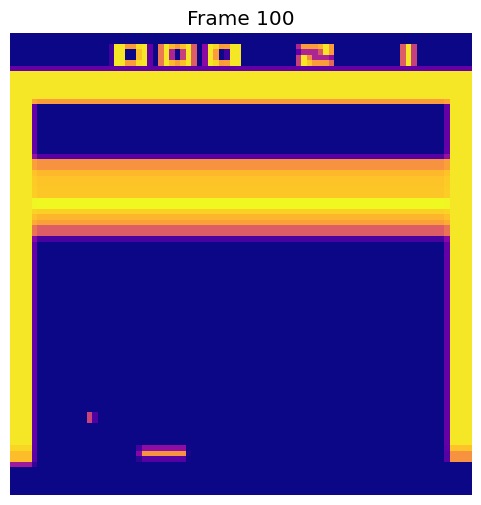

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


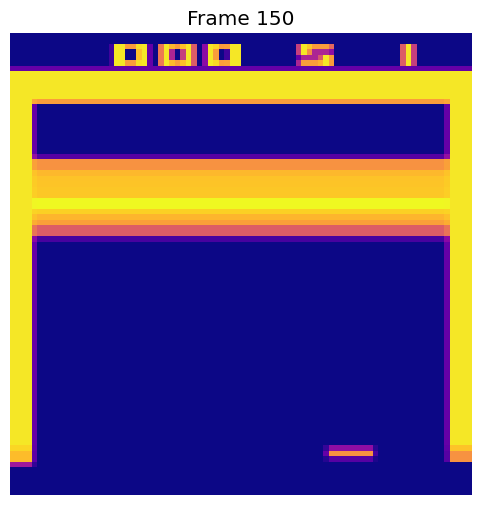

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


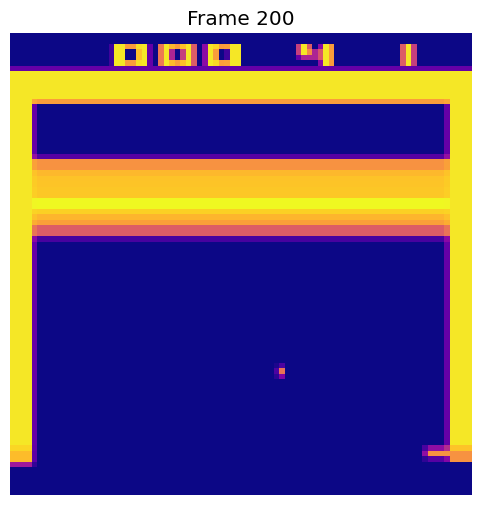

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


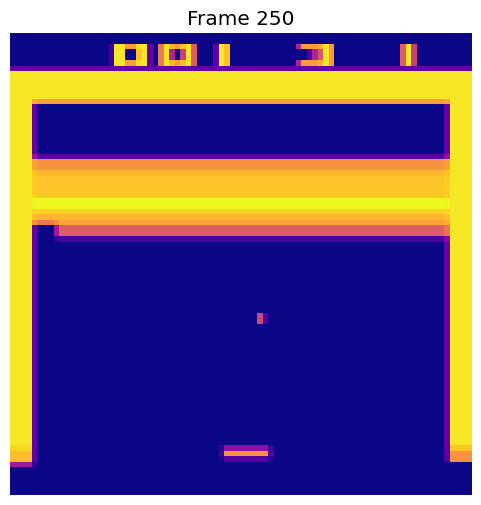

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


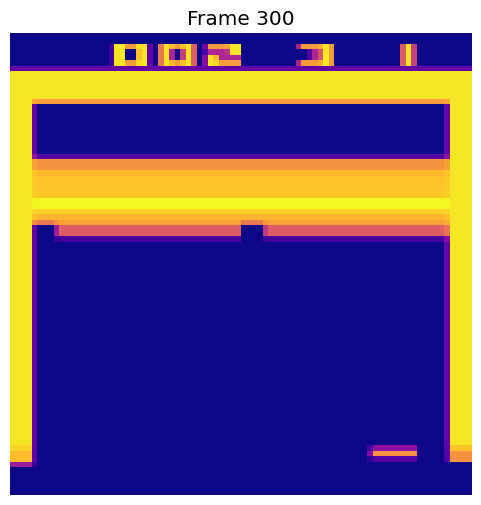

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


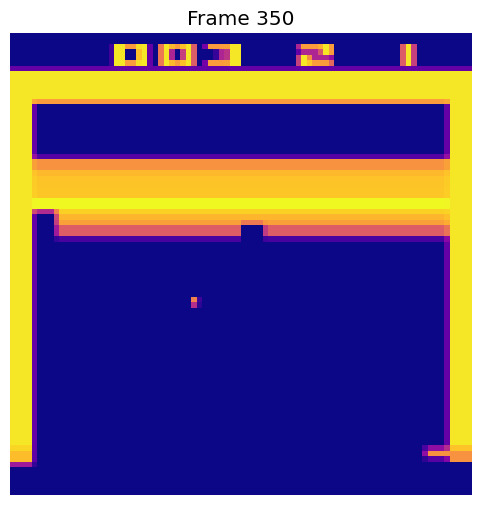

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


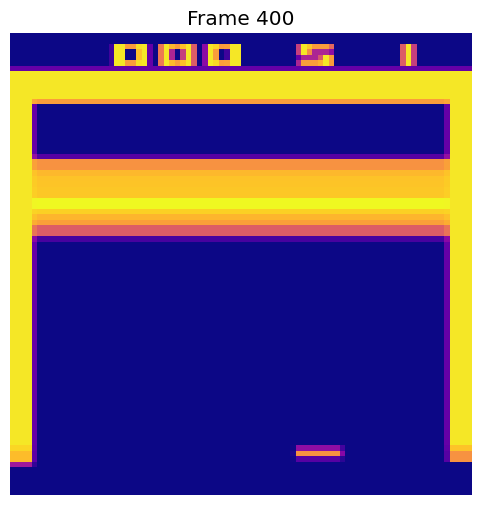

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


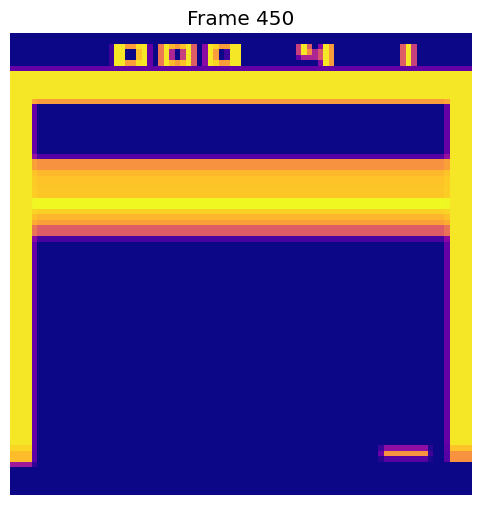

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


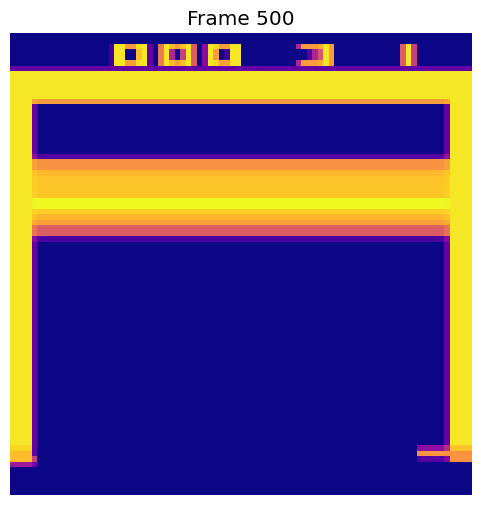

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


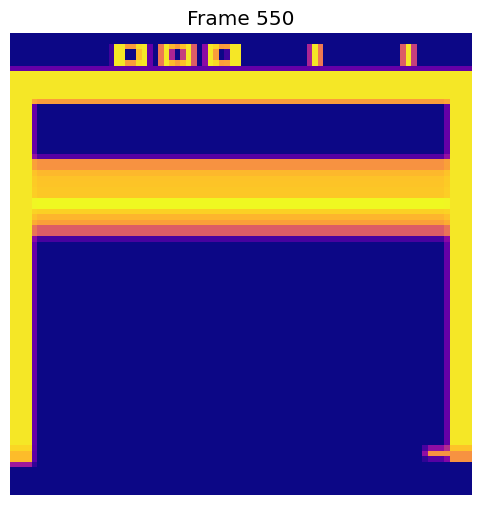

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


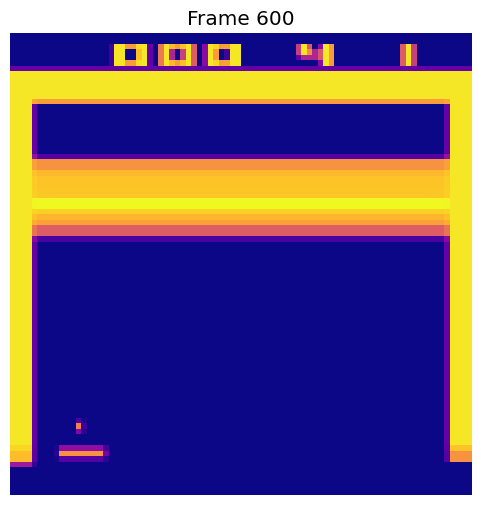

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


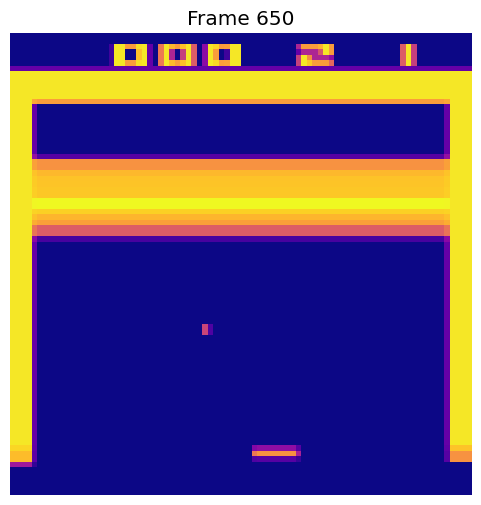

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


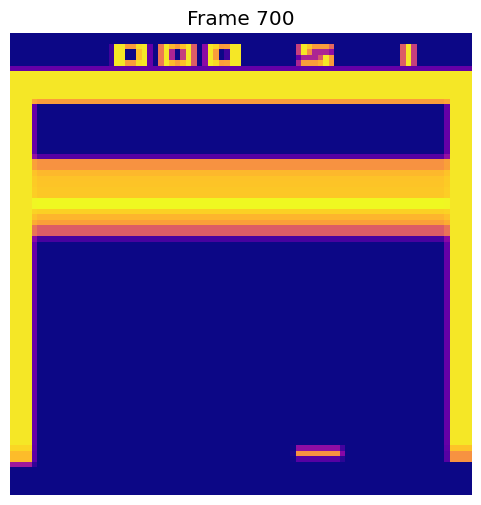

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


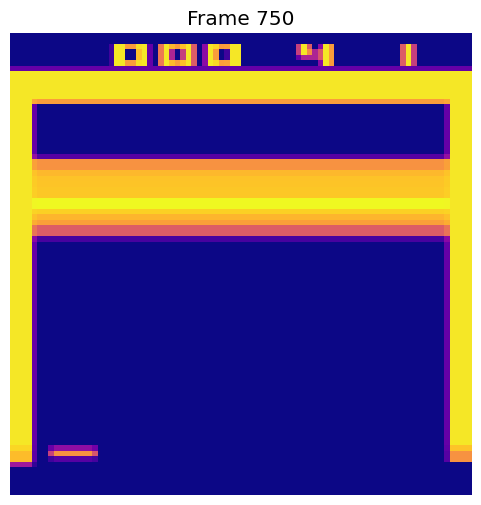

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


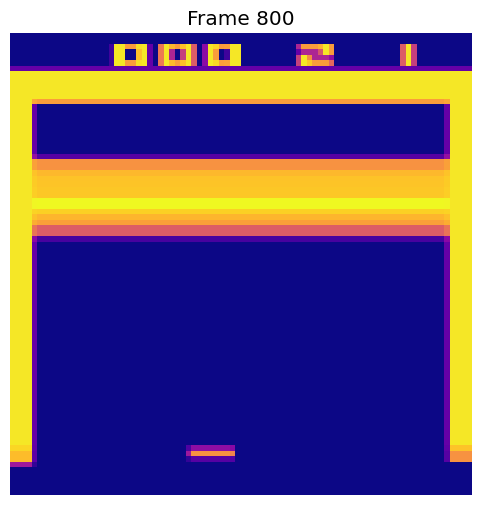

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


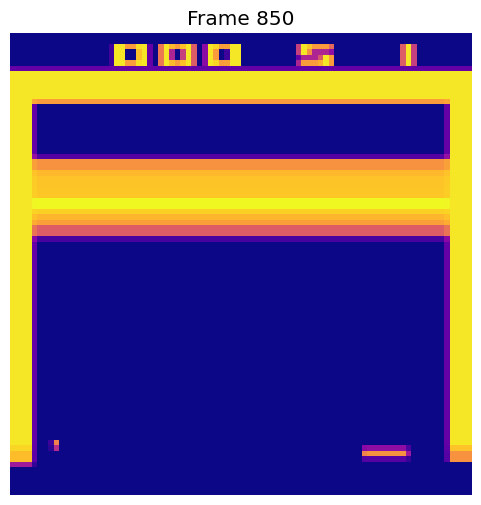

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


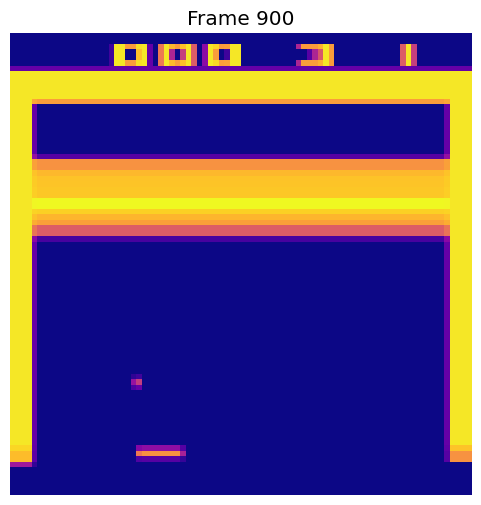

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


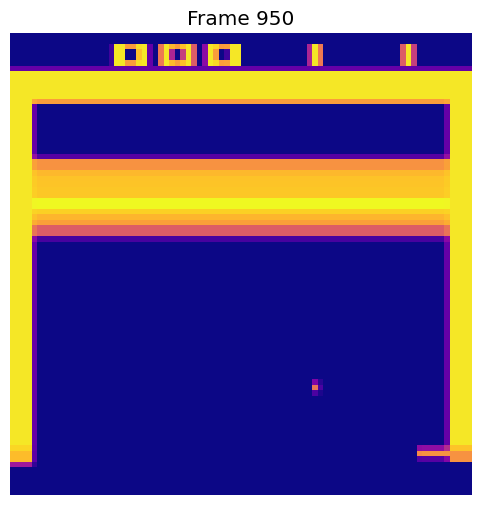

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


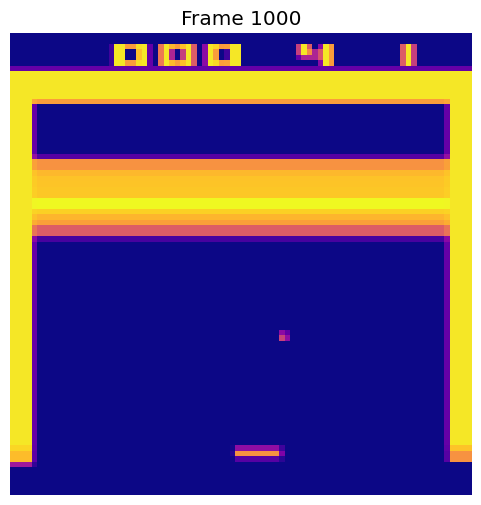

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


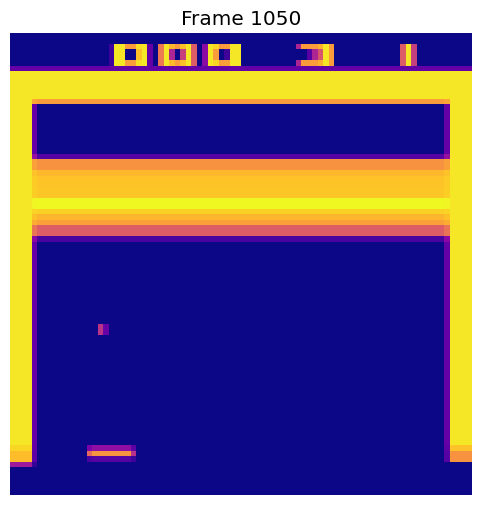

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


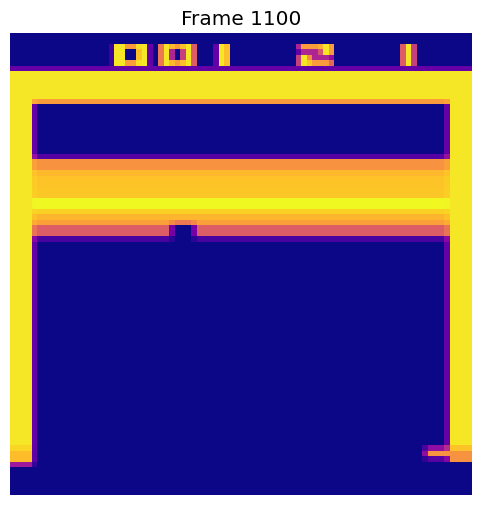

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


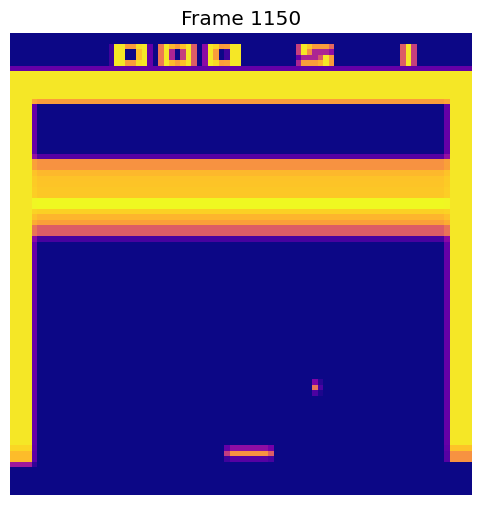

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


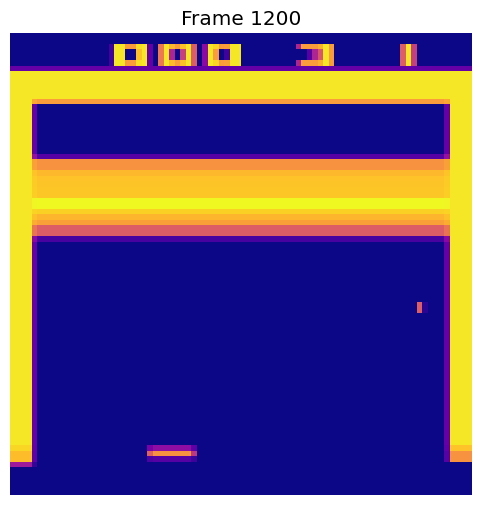

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


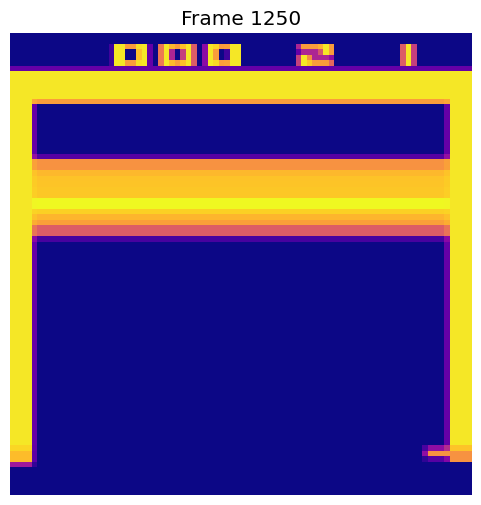

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


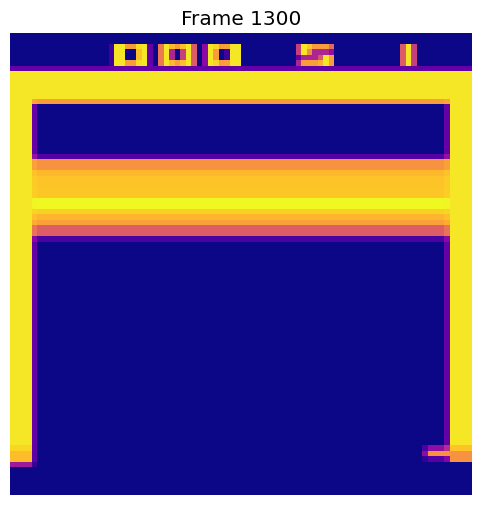

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


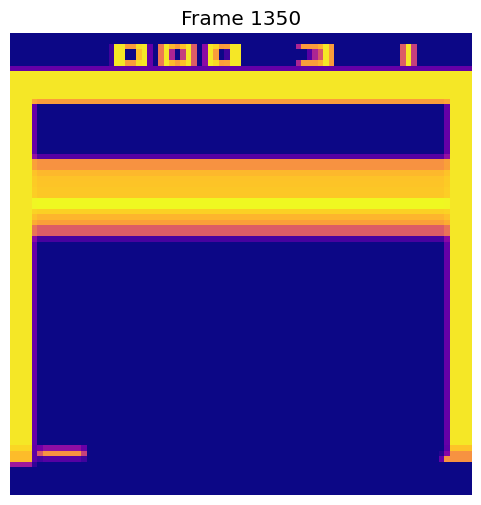

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


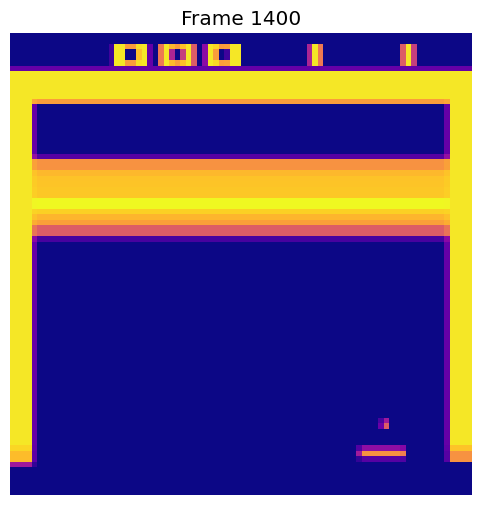

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


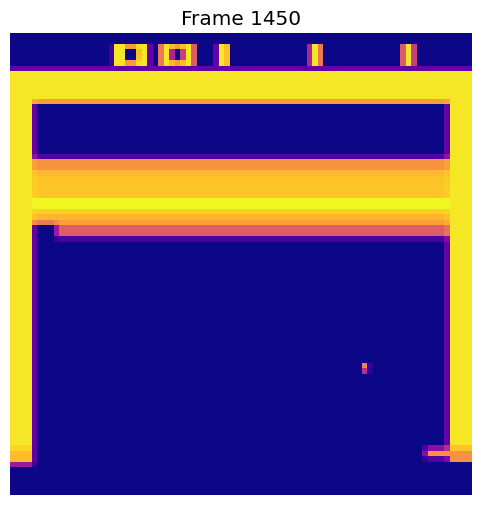

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


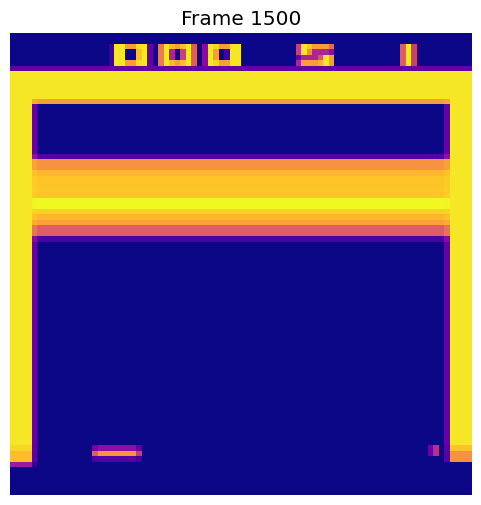

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


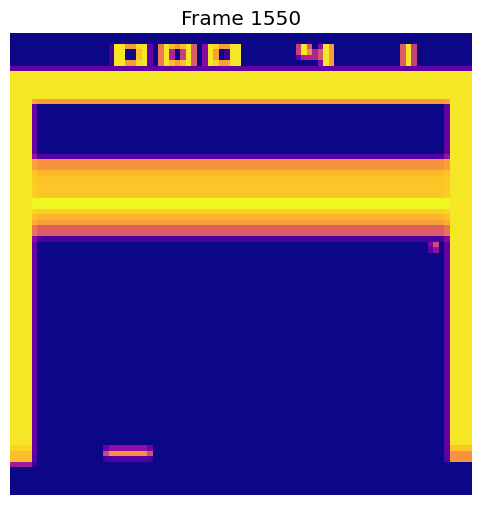

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


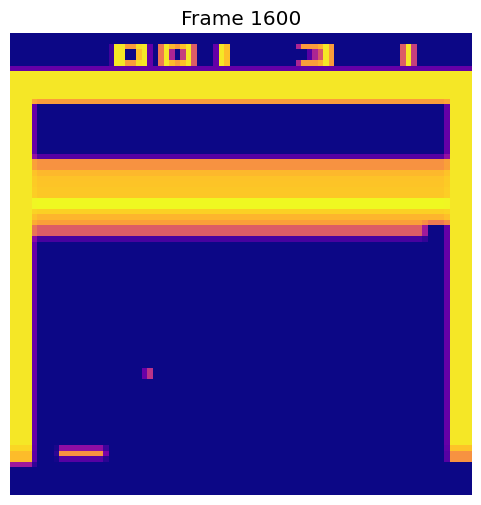

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


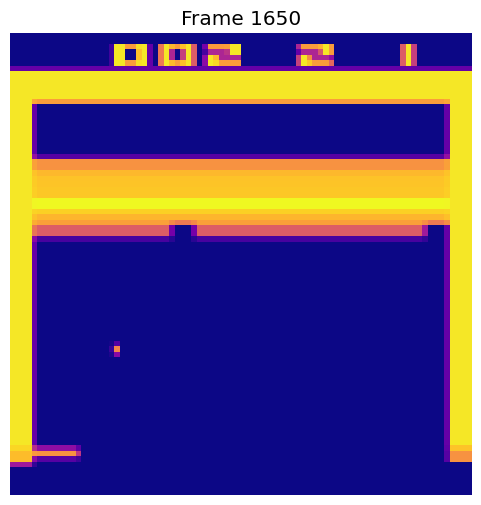

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


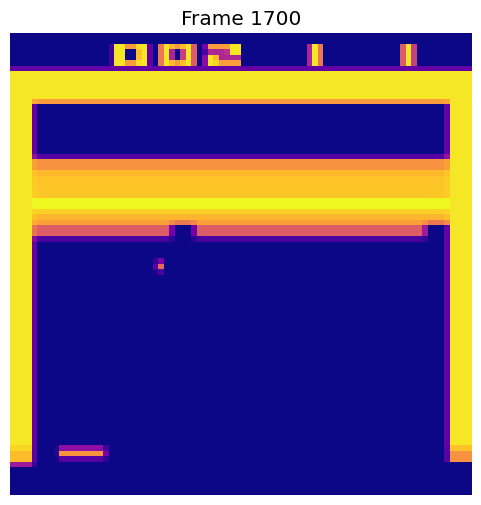

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Stopped at episode 10!


In [8]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# imporves training time
optimizer=keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history=[]
state_history=[]
state_next_history=[]
rewards_history=[]
done_history=[]
episode_reward_history=[]
running_reward=0
episode_count=0
frame_count=0

# Store the metrics for plotting
# clipped_rewards=[]
unclipped_rewards=[]
training_loss=[]

# Number of grames to take random action and observe output
epsilon_random_frames=50000

# Number of frames for exploration
epsilon_greedy_frames=1000000.0

# Maximum replay length
# Note: The Deepmind paper suggest 1000000 however this causes memory issues
max_memory_length=100000

# Train the model after 4 actions
update_after_actions=4

# How often to update the target network
update_target_network=10000

# Using huber loss for stability
loss_function=keras.losses.Huber()


while True:
  observation, _=env.reset()
  state=np.array(observation)
  episode_reward=0

  for timestep in range(1, max_steps_per_episode):
    frame_count+=1

    # Capture an image of the environment every 50 frames
    if frame_count%50==0:
      save_env_images(state, frame_count)

    # Use epsilon-greedy for exploration
    if frame_count<epsilon_random_frames or epsilon>np.random.rand(1)[0]:
      # Take random action
      action=np.random.choice(num_actions)
    else:
      # Predict action Q-values from environment state
      state_tensor=keras.ops.convert_to_tensor(state)
      state_tensor=keras.ops.expand_dims(state_tensor, 0)
      action_probs=model(state_tensor, training=False)
      # Take best action
      action=keras.ops.argmax(action_probs[0]).numpy()

    # Decay probability of taking random action
    epsilon-=epsilon_interval/epsilon_greedy_frames
    epsilon=max(epsilon, epsilon_min)

    # Apply the sampled action in our environment
    state_next, reward, done, _, _=env.step(action)
    stat_next=np.array(state_next)

    episode_reward+=reward

    # Store Unclipped reward
    unclipped_rewards.append(episode_reward)

    # Save actions and states in replay buffer
    action_history.append(action)
    state_history.append(state)
    state_next_history.append(state_next)
    done_history.append(done)
    rewards_history.append(reward)
    state=state_next

    # Update every fourth frame and once batch size is over 32
    if frame_count%update_after_actions==0 and len(done_history)>batch_size:
      # Get indices of samples for replay buffers
      indices=np.random.choice(range(len(done_history)), size=batch_size)

      # Using list comprehension to sample from replay buffer
      state_sample=np.array([state_history[i] for i in indices])
      state_next_sample=np.array([state_next_history[i] for i in indices])
      rewards_sample=[rewards_history[i] for i in indices]
      action_sample=[action_history[i] for i in indices]
      done_sample=keras.ops.convert_to_tensor(
          [float(done_history[i]) for i in indices]
      )

      # Build the updated Q-values for the sampled future states
      # Use the target model for stability
      future_rewards=model_target.predict(state_next_sample)
      # Q value = reward + discount factor * expected future reward
      updated_q_values=rewards_sample+gamma*keras.ops.max(
          future_rewards, axis=1
      )

      # If final frame set the last value to -1
      updated_q_values=updated_q_values*(1-done_sample)-done_sample

      # Create a mask so we only calculate loss on the updated Q-values
      masks=keras.ops.one_hot(action_sample, num_actions)

      with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values=model(state_sample)

        # Apply the masks to the Q-values to get the Q-value for action taken
        q_action=keras.ops.sum(keras.ops.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss=loss_function(updated_q_values, q_action)

      # Store trainning loss
      training_loss.append(loss)

      # Backpropagation
      grads=tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if frame_count % update_target_network == 0:
      # Update the target network with new weights
      model.target.set_weights(model.get_weights())
      # Log details
      template="Running Reward: {:.2f} at Episode {}, Frame Count {}"
      print(template.format(running_reward, episode_count, frame_count))

    # Limit the state and reward history
    if len(rewards_history)>max_memory_length:
      del rewards_history[:1]
      del state_history[:1]
      del state_next_history[:1]
      del action_history[:1]
      del done_history[:1]

    if done:
      break

  # Update running reward to check condition for solving
  episode_reward_history.append(episode_reward)
  if len(episode_reward_history)>100:
    del episode_reward_history[:1]
  running_reward=np.mean(episode_reward_history)

  episode_count+=1

  if running_reward>40:                                   # Condition to consider the task solved
    print("Solved at episode {}!".format(episode_count))
    break

  if(max_episodes>0 and episode_count>=max_episodes):     # Macimum number of episodes reached
    print("Stopped at episode {}!".format(episode_count))
    break


## Discussion

### Unclipped Reward Graph Results

The graph of unclipped rewards shows a fluctuating pattern over the course of the training process, indicating the agent's varying performance in the Atari Breakout environment. 

1. **Initial Reward Patterns (Frames 240-270)**:
   - Between frames 240 and 270, the rewards oscillate between values of 1, 2, and 3. This fluctuation suggests that the agent is beginning to learn the mechanics of the game, managing to score points intermittently. The presence of varied rewards indicates that the agent is engaging with the environment in different ways, successfully achieving certain tasks or making beneficial moves that lead to incremental scoring.

2. **Stability in Performance (Frames 1050-1070)**:
   - At frame 1050, the reward stabilizes at 1 for a period, which could imply that the agent is consistently performing actions that yield minimal rewards. This stagnation might reflect a learning plateau, where the agent has not yet discovered more effective strategies or is repeatedly executing actions that lead to low-point scenarios. The consistency in low rewards could also suggest a need for further exploration or adjustment in the training parameters to encourage more diverse actions.

3. **Reinforcement of Learning (Frame 1300)**:
   - A single reward of 1 is noted at frame 1300. This isolated reward reinforces the previous observation of the agent’s tendency to default to less rewarding actions. It could indicate a lack of adaptability or an insufficient exploration strategy at this point in training, signaling the need for adjustments in the epsilon-greedy exploration mechanism.

4. **Increase in Reward Values (Frame 1400)**:
   - At frame 1400, the reward increases to 2, suggesting a moment of improved performance or a better decision made by the agent. This uptick in reward may indicate that the agent has learned from prior experiences and is beginning to make more optimal choices. The increasing reward values suggest a potential shift in the agent’s strategy, which could lead to more consistent scoring if maintained.

5. **Fluctuations in Rewards (Frames 1550-1750)**:
   - Between frames 1550 and 1750, the agent experiences a range of rewards (1, 2, and 3), which indicates a resurgence in its ability to score points effectively. This variability might reflect a phase of active learning where the agent is trying out different strategies or is responding well to the dynamics of the environment. The presence of higher rewards during this stretch suggests that the agent is gradually mastering the game mechanics and beginning to exploit them more effectively.

#### Conclusion
Overall, the variations in unclipped rewards over time highlight the learning trajectory of the agent as it navigates the complexities of the Atari Breakout game. The initial fluctuations indicate early stages of learning, followed by periods of low rewards suggesting potential plateaus. However, the subsequent increases in reward values demonstrate the agent's evolving strategies and adaptation to the environment. Continuous monitoring and adjustments to the training regime may be necessary to optimize performance and facilitate more significant breakthroughs in reward scoring as training progresses.

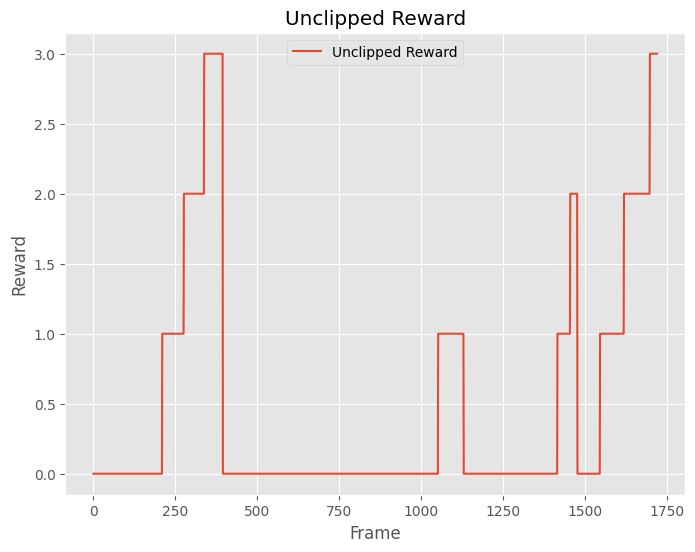

In [9]:
# Unclipped Reward
plt.figure(figsize=(8, 6))
plt.plot(unclipped_rewards, label='Unclipped Reward')
plt.xlabel('Frame')
plt.ylabel('Reward')
plt.title('Unclipped Reward')
plt.legend()
plt.show()

### Training Loss Graph Results

The Training Loss graph provides crucial insights into the learning dynamics of the Deep Q-Learning model as it trains in the Atari Breakout environment. 

1. **Initial High Loss Values (Frame 0)**:
   - At the start of the training process (frame 0), the loss value is approximately 8, indicating that the model's predictions are significantly deviating from the actual Q-values. This high loss suggests that the model has not yet learned effective representations of the game environment, resulting in poor performance in estimating future rewards. 

2. **Subsequent Increase in Loss (Early Frames)**:
   - Following the initial value, the loss increases slightly to around 16 within just a few frames. This rise could be attributed to the model's attempts to adapt to the new environment. The sudden increase might indicate that the model is struggling to find stable Q-values due to the randomness inherent in initial actions and the exploration strategy being employed. This behavior can be common in early training phases, where the model is still trying to find a balance between exploration and exploitation.

3. **Sharp Decrease in Loss**:
   - After reaching a peak around frame 16, the training loss begins to decrease sharply, eventually stabilizing close to zero. This significant reduction in loss signifies that the model has started to learn more effectively from its experiences. The downward trend indicates that the Q-value predictions are becoming more accurate as the agent gains insights from the environment, successfully associating actions with their respective rewards. 

4. **Stabilization of Loss (Post Frame 16)**:
   - The stabilization of the training loss at near-zero values for the remainder of the training process suggests that the model has effectively learned to predict Q-values with a high degree of accuracy. This consistent low loss reflects the model's ability to generalize from its experiences, indicating that it has internalized the patterns and strategies necessary for achieving higher scores in the game. 

#### Conclusion
Overall, the Training Loss graph illustrates a positive trajectory in the model's learning process. The initial high values and subsequent fluctuations reflect the challenges faced during early training, while the eventual sharp decline and stabilization at low loss values demonstrate successful adaptation and improvement. These results underscore the effectiveness of the training regimen and suggest that the model is well on its way to mastering the Atari Breakout environment. Continuous monitoring and adjustments can further enhance performance, ensuring that the agent maintains its learning momentum.

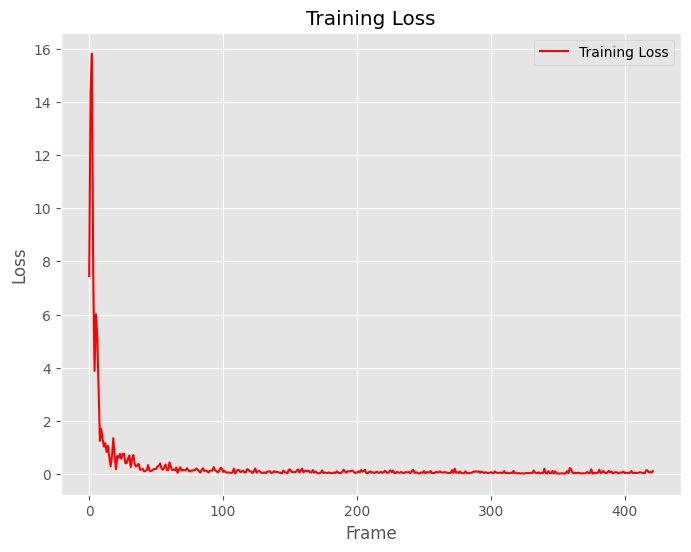

In [10]:
# Training Loss
plt.figure(figsize=(8, 6))
plt.plot(training_loss, label='Training Loss', color='red')
plt.xlabel('Frame')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

### Conclusion of the Deep Q-Learning for Atari Breakout Project

This project successfully implemented a Deep Q-Learning algorithm to train an agent to play Atari Breakout, demonstrating the effectiveness of reinforcement learning in mastering complex environments. The approach utilized a convolutional neural network (CNN) to process game frames and predict Q-values, enabling the agent to make informed decisions based on its observations.

Key components of the project included:

1. **Environment Setup**: The Atari Breakout environment was configured using OpenAI's Gym, and preprocessing techniques were applied to enhance the input frames, including frame stacking and normalization.

2. **Model Architecture**: A CNN model was developed in accordance with the DeepMind paper, consisting of several convolutional layers followed by dense layers. This architecture allowed the agent to extract relevant features from the game frames effectively.

3. **Training Process**: The agent was trained using an epsilon-greedy strategy, balancing exploration and exploitation. Experience replay was implemented to improve learning stability, and the Huber loss function was employed to mitigate the impact of outliers in the Q-value updates.

4. **Performance Metrics**: Throughout the training, various metrics were monitored, including training loss and unclipped rewards. The training loss exhibited a significant decrease over time, indicating the model's learning efficiency, while the reward structure showed a gradual improvement in the agent's performance.

5. **Image Capturing**: The project also incorporated functionality to visualize and save frames from the environment during training, allowing for a better understanding of the agent's interactions with the game.

In conclusion, the project not only demonstrated the practical application of Deep Q-Learning in a classic game but also highlighted the challenges and solutions associated with training reinforcement learning agents. The results indicate a well-trained model capable of playing Breakout effectively, providing a foundation for further experimentation and improvements in reinforcement learning methodologies. Future work may focus on refining the model, exploring different architectures, and applying similar techniques to other Atari games or environments, further expanding the capabilities of AI in gaming and decision-making scenarios.